# Flux point fitting in Gammapy


## Introduction

In this tutorial we're going to learn how to fit spectral models to combined Fermi-LAT and IACT flux points.

The central class we're going to use for this example analysis is:  

- [gammapy.spectrum.FluxPointFitter](http://docs.gammapy.org/dev/api/gammapy.spectrum.FluxPointFitter.html)

In addition we will work with the following data classes:

- [gammapy.spectrum.FluxPoints](http://docs.gammapy.org/dev/api/gammapy.spectrum.FluxPoints.html)
- [gammapy.catalog.SourceCatalogGammaCat](http://docs.gammapy.org/dev/api/gammapy.catalog.SourceCatalogGammaCat.html)
- [gammapy.catalog.SourceCatalog3FHL](http://docs.gammapy.org/dev/api/gammapy.catalog.SourceCatalog3FHL.html)
- [gammapy.catalog.SourceCatalog3FGL](http://docs.gammapy.org/dev/api/gammapy.catalog.SourceCatalog3FGL.html)

And the following spectral model classes:

- [PowerLaw](http://docs.gammapy.org/dev/api/gammapy.spectrum.models.PowerLaw.html)
- [ExponentialCutoffPowerLaw](http://docs.gammapy.org/dev/api/gammapy.spectrum.models.ExponentialCutoffPowerLaw.html)
- [LogParabola](http://docs.gammapy.org/dev/api/gammapy.spectrum.models.LogParabola.html)

## Setup

Let us start with the usual IPython notebook and Python imports:

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [8]:
from astropy import units as u
from gammapy.spectrum.models import (
    PowerLaw,
    ExponentialCutoffPowerLaw,
    LogParabola,
)
from gammapy.spectrum import FluxPointFitter, FluxPoints
from gammapy.catalog import (
    SourceCatalog3FGL,
    SourceCatalogGammaCat,
    SourceCatalog3FHL,
)

## Load spectral points

For this analysis we choose to work with the source 'HESS J1507-622' and the associated Fermi-LAT sources '3FGL J1506.6-6219' and '3FHL J1507.9-6228e'. We load the source catalogs, and then access source of interest by name:

In [3]:
fermi_3fgl = SourceCatalog3FGL()
fermi_3fhl = SourceCatalog3FHL()
gammacat = SourceCatalogGammaCat()

In [4]:
source_gammacat = gammacat["HESS J1507-622"]
source_fermi_3fgl = fermi_3fgl["3FGL J1506.6-6219"]
source_fermi_3fhl = fermi_3fhl["3FHL J1507.9-6228e"]

The corresponding flux points data can be accessed with `.flux_points` attribute:

In [5]:
flux_points_gammacat = source_gammacat.flux_points
flux_points_gammacat.table

e_ref,dnde,dnde_errn,dnde_errp
TeV,1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV)
float32,float32,float32,float32
0.8609004,2.29119e-12,8.705427e-13,8.955021e-13
1.561512,6.981717e-13,2.203541e-13,2.304066e-13
2.763753,1.690615e-13,6.758698e-14,7.188384e-14
4.891597,7.729249e-14,2.401318e-14,2.607487e-14
9.988584,1.032534e-14,5.063147e-15,5.641954e-15
27.04035,7.449867e-16,5.72089e-16,7.259987e-16


In the Fermi-LAT catalogs, integral flux points are given. Currently the flux point fitter only works with differential flux points, so we apply the conversion here.

In [6]:
flux_points_3fgl = source_fermi_3fgl.flux_points.to_sed_type(
    sed_type="dnde", model=source_fermi_3fgl.spectral_model
)
flux_points_3fhl = source_fermi_3fhl.flux_points.to_sed_type(
    sed_type="dnde", model=source_fermi_3fhl.spectral_model
)

Finally we stack the flux points into a single `FluxPoints` object and drop the upper limit values, because currently we can't handle them in the fit:

In [9]:
# stack flux point tables
flux_points = FluxPoints.stack(
    [flux_points_gammacat, flux_points_3fhl, flux_points_3fgl]
)

# drop the flux upper limit values
flux_points = flux_points.drop_ul()

## Fitter Setup

We initialze the fitter object with the `'chi2assym'` statistic, because we have assymmetric errors on the flux points. As optimizer we choose the `'simplex'` algorithm and to estimate the errors we use `'covar'` method: 

In [10]:
fitter = FluxPointFitter(
    stat="chi2assym", optimizer="minuit", opts_minuit={"print_level": 1}
)

## Power Law Fit

First we start with fitting a simple [power law](http://docs.gammapy.org/dev/api/gammapy.spectrum.models.PowerLaw.html#gammapy.spectrum.models.PowerLaw).

In [12]:
pwl = PowerLaw(
    index=2, amplitude=1e-12 * u.Unit("cm-2 s-1 TeV-1"), reference=1. * u.TeV
)

After creating the model we run the fit by passing the `'flux_points'` and `'pwl'` objects:

In [13]:
result_pwl = fitter.run(flux_points, pwl)

FCN = 33.68333436236992 
 TOTAL NCALL = 40 
 NCALLS = 40 
 
 
 EDM = 6.320959907067041e-06 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,par_000_index,1.96557,0.0265129,0,0,,,
2,par_001_amplitude,1.34465,0.159456,0,0,,,
3,par_002_reference,1,1,0,0,0.0,,FIXED


And print the result:

In [14]:
print(result_pwl["best-fit-model"])

PowerLaw

Parameters: 

	   name     value     error         unit         min    max
	--------- --------- --------- --------------- --------- ---
	    index 1.966e+00 2.651e-02                       nan nan
	amplitude 1.345e-12 1.595e-13 1 / (cm2 s TeV)       nan nan
	reference 1.000e+00 0.000e+00             TeV 0.000e+00 nan

Covariance: 

	   name            index                 amplitude        reference
	--------- ----------------------- ----------------------- ---------
	    index   0.0007029315497909933 -2.2295559642505204e-15       0.0
	amplitude -2.2295559642505204e-15   2.542624869909827e-26       0.0
	reference                     0.0                     0.0       0.0


As a quick check we print the value of the fit statistics per degrees of freedom as well:

In [15]:
print(result_pwl["statval/dof"])

2.405952454454994


Finally we plot the data points and the best fit model:

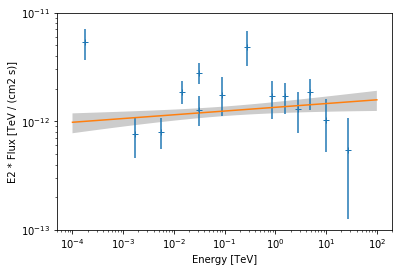

In [17]:
ax = flux_points.plot(energy_power=2)
result_pwl["best-fit-model"].plot(
    energy_range=[1e-4, 1e2] * u.TeV, ax=ax, energy_power=2
)
result_pwl["best-fit-model"].plot_error(
    energy_range=[1e-4, 1e2] * u.TeV, ax=ax, energy_power=2
)
ax.set_ylim(1e-13, 1e-11);

## Exponential Cut-Off Powerlaw Fit

Next we fit an [exponential cut-off power](http://docs.gammapy.org/dev/api/gammapy.spectrum.models.ExponentialCutoffPowerLaw.html#gammapy.spectrum.models.ExponentialCutoffPowerLaw) law to the data.

In [18]:
ecpl = ExponentialCutoffPowerLaw(
    index=2,
    amplitude=1e-12 * u.Unit("cm-2 s-1 TeV-1"),
    reference=1. * u.TeV,
    lambda_=0.1 / u.TeV,
)

We run the fitter again by passing the flux points and the `ecpl` model instance:

In [19]:
result_ecpl = fitter.run(flux_points, ecpl)
print(result_ecpl["best-fit-model"])

FCN = 25.346710867466356 
 TOTAL NCALL = 109 
 NCALLS = 109 
 
 
 EDM = 2.4546721170305025e-05 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,par_000_index,1.87622,0.045174,0,0,,,
2,par_001_amplitude,2.07694,0.410548,0,0,,,
3,par_002_reference,1,1,0,0,,,FIXED
4,par_003_lambda_,0.870321,0.569926,0,0,,,


ExponentialCutoffPowerLaw

Parameters: 

	   name     value     error         unit      min max
	--------- --------- --------- --------------- --- ---
	    index 1.876e+00 4.517e-02                 nan nan
	amplitude 2.077e-12 4.105e-13 1 / (cm2 s TeV) nan nan
	reference 1.000e+00 0.000e+00             TeV nan nan
	  lambda_ 8.703e-02 5.699e-02         1 / TeV nan nan

Covariance: 

	   name            index          ... reference        lambda_        
	--------- ----------------------- ... --------- ----------------------
	    index   0.0020406903357166645 ...       0.0 -0.0018317388205122843
	amplitude -1.5063001330406742e-14 ...       0.0 1.8513933632728653e-14
	reference                     0.0 ...       0.0                    0.0
	  lambda_  -0.0018317388205122843 ...       0.0  0.0032481547755154796


In [20]:
print(result_ecpl["statval/dof"])

1.9497469898051043


We plot the data and best fit model:

(1e-13, 1e-11)

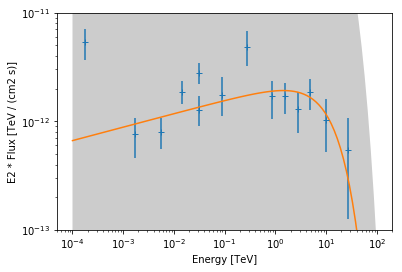

In [27]:
ax = flux_points.plot(energy_power=2)
result_ecpl["best-fit-model"].plot(
    energy_range=[1e-4, 1e2] * u.TeV, ax=ax, energy_power=2
)
result_ecpl["best-fit-model"].plot_error(
    energy_range=[1e-4, 1e2] * u.TeV, ax=ax, energy_power=2
)
ax.set_ylim(1e-13, 1e-11)

## Log-Parabola Fit

Finally we try to fit a [log-parabola](http://docs.gammapy.org/dev/api/gammapy.spectrum.models.LogParabola.html#gammapy.spectrum.models.LogParabola) model:

In [22]:
log_parabola = LogParabola(
    alpha=2,
    amplitude=1e-12 * u.Unit("cm-2 s-1 TeV-1"),
    reference=1. * u.TeV,
    beta=0.1 * u.Unit(""),
)

In [23]:
result_log_parabola = fitter.run(flux_points, log_parabola)
print(result_log_parabola["best-fit-model"])

FCN = 20.460238483199046 
 TOTAL NCALL = 113 
 NCALLS = 113 
 
 
 EDM = 7.691126166140908e-05 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,par_000_amplitude,1.95313,0.279909,0,0,,,
2,par_001_reference,1,1,0,0,,,FIXED
3,par_002_alpha,2.16053,0.0741247,0,0,,,
4,par_003_beta,0.538531,0.176316,0,0,,,


LogParabola

Parameters: 

	   name     value     error         unit      min max
	--------- --------- --------- --------------- --- ---
	amplitude 1.953e-12 2.799e-13 1 / (cm2 s TeV) nan nan
	reference 1.000e+00 0.000e+00             TeV nan nan
	    alpha 2.161e+00 7.412e-02                 nan nan
	     beta 5.385e-02 1.763e-02                 nan nan

Covariance: 

	   name         amplitude        ...          beta        
	--------- ---------------------- ... ---------------------
	amplitude  7.834881029385038e-26 ... 2.184394043762759e-15
	reference                    0.0 ...                   0.0
	    alpha 1.7533444701729213e-15 ...  0.001127482629098929
	     beta  2.184394043762759e-15 ... 0.0003108748112288561


In [24]:
print(result_log_parabola["statval/dof"])

1.573864498707619


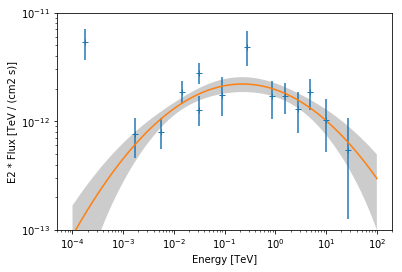

In [26]:
ax = flux_points.plot(energy_power=2)
result_log_parabola["best-fit-model"].plot(
    energy_range=[1e-4, 1e2] * u.TeV, ax=ax, energy_power=2
)
result_log_parabola["best-fit-model"].plot_error(
    energy_range=[1e-4, 1e2] * u.TeV, ax=ax, energy_power=2
)
ax.set_ylim(1e-13, 1e-11);

## Exercises

- Fit a `PowerLaw2` and `ExponentialCutoffPowerLaw3FGL` to the same data.
- Fit a `ExponentialCutoffPowerLaw` model to Vela X ('HESS J0835-455') only and check if the best fit values correspond to the values given in the Gammacat catalog

## What next?

This was an introduction to SED fitting in Gammapy.

* If you would like to learn how to perform a full Poisson maximum likelihood spectral fit, please check out the [spectrum pipe](spectrum_pipe.ipynb) tutorial.
* If you are interested in simulation of spectral data in the context of CTA, please check out the [spectrum simulation cta](spectrum_simulation_cta.ipynb) notebook.
* To learn more about other parts of Gammapy (e.g. Fermi-LAT and TeV data analysis), check out the other tutorial notebooks.
* To see what's available in Gammapy, browse the [Gammapy docs](http://docs.gammapy.org/) or use the full-text search.
* If you have any questions, ask on the mailing list .